# title

subtitle

Isaiah Espinoza (University of Maryland)  
2024-10-16

In [ ]:
# load packages
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

In [ ]:
# Some post-processing of the dataframe :::::::::::::::::::::::::::::::::::::###

# recode factor levels 
data <- data |> 
  # use `pewmethods` to preserve order of factor levels
  mutate(across(c(q19, q20, q21, q22, q23,q24, q25, q26,
                  q30, q31, q32, q33, q34, q35, q36, q37), 
                ~pewmethods::fct_case_when(
    .x == "Not at all confident" |
      .x == "Not at all committed" ~ "Not at all",
    .x == "Not too confident" |
      .x == "Not too committed"|
      .x == "Not too concerned"|
      .x == "Somewhat unconcerned" ~ "Not that much",
    .x == "Somewhat confident" |
      .x == "Somewhat committed" ~ "Somewhat",
    .x == "Very confident" |
      .x == "Very committed" ~ "Very",
    TRUE ~ NA
  )))


# re-assign var labels to variables
# To quickly assign the variable labels, first create a named vector via
# deframe() with values as the variable labels and names as the variable names.
data_labels <- data_dict |>
  select(var, label_var) |> 
  deframe()

# Now assign the labels using the splice operator. Using the splice operator,
# labels are assigned via matching against the variable name, which means that
# variable order does not matter.
data <- data |> 
  labelled::set_variable_labels(!!!data_labels)

In [ ]:
source(here::here('src', 'funs.R'))

## Introduction

Election administration officials make efforts to sustain public trust and confidence in the fairness and accuracy of elections, and attempt to boost such confidence where it may be deprived. Concerns for safety have developed among election staff and voters in more recent elections. Regular measures are taken to enhance the *trustworthiness*[1] of the electoral process through practices meant to improve the conduct, transparency, or overall administration of elections in the United States.

Although election officials undertake great efforts to enhance the trustworthiness of election administration, public *trust* in elections is a psychological construct influenced by many things outside of election official control such as partisanship or elite rhetoric \[@hooghe2018; @sances2015\]. Moreover, a person’s evaluation of the election in hindsight is often influenced by the election outcome itself \[@daniller2019; @stewart2022\]. Thus, measures taken by election officials can be undermined, trivialized, or made irrelevant depending on how one feels after the election results have come out.

Such volatile attitudes and evaluations post-election can leave a lasting impression that election officials must contend with upon the next election cycle \[@levendusky2024; @bowler2024\]. For instance, we have witnessed many people’s outright refusal to accept the 2020 U.S. election results as legitimate despite consistent review of the evidence confirming the results as fair and accurate. Such a case demonstrates that public trust in elections is, at best, only partial to trustworthiness of election administration in the United States[2].

Even though election officials can do a lot to secure election integrity, there’s not much they can do to cement public confidence after election night passes. At best, election officials can ease public anxieties prior to election night.

One point of contention that election officials have faced in the past regard evaluation of election workers. Previous literature has focused on how voter interaction with election workers \[@claassen2008\], or the voter experience generally \[@atkeson2007\], influences evaluations of election administration. As such, election worker competency has been examined as a factor significant to evaluations of performance of elections \[@hall2007; @hall2009\]. However, considering that individual perceptions and preconceived notions play a huge role in cognition \[@cikara2014; @vanbavel2021\], it is reasonable to expect that the group an election worker hails from would be an important influence upon the voter’s evaluation of the electoral process.

Supposing such is the case, we can expect that information about *who* (i.e., which groups) election officials are targeting in publicized recruitment efforts would lessen particular election anxieties. That is to say, it is reasonable to expect that telling people *who* will be working as election staff and volunteers would ease election anxieties, therefore improve confidence that the election will be conducted fairly, accurately, and safe for all involved.

In this paper, I report results from a recent survey experiment administered to test whether publicized efforts to recruit veterans to work as election staff and volunteers would improve public trust in elections and ease election anxieties. Results of the survey experiment support the hypothesis that emphasizing veterans as the target of election worker recruitment efforts eases pre-elections anxieties to an extent. In particular, among those in the treatment condition, confidence that the elections would be fair and accurate was higher in comparison to those in the control. In addition, expectations of electoral fraud were lower, as were concerns for voter safety compared to those who read a control vignette. Notable is that there was a significant difference in confidence, and lower expectations of fraud, among those in the treatment condition who believe that the 2020 election was illegitimate.

\[Insert why this is an important contribution\]

This paper is structured as follows. First, I provide a brief background on public trust in election administration. Second, I synthesize a review of relevant literature with a focus on how political and social science has conceptualized and ascertained public trust in elections. Next, I supply reasoning for why military veterans are singled out as the relevant subset of the population in this study.

-   when distinguished by partisanship…
-   moreover, broken down by other demographic variables such as race, gender, education, etc.
-   holding these factors constant demonstrates a \[increased/decreased\] likelihood that a respondent’s confidence would likely \[increase/decrease\], expectations of fraud would likely \[increase/decrease\], and concerns for safety would lessen among those in the treatment group compared to those in the control. These results allow us to attribute the differences to the treatment stimulus, namely, the prospect of having veterans serve as election staff or volunteers.

## Background: Election Administration and Public Confidence

Election officials have tried hard to inspire confidence in the administration and conduct of elections by improving the degree to which elections are trustworthy. Development and implementation of procedures such as post-election auditing of ballots and logic-and-accuracy testing of ballot tabulation equipment are prominent examples adding to the long history of efforts to enhance the trustworthiness of election administration in the United States.

Prior to the year 2000, one of the main issues facing election administration was recruiting enough election workers to volunteer at the polls (i.e., poll workers) \[@maidenberg1996\]. Election worker recruitment is still much of an issue in the current era as it was then, perhaps worse \[@ferrer2024\]. In addition to ensuring election admin offices were adequately staffed, the controversy of the 2000 general election made the public more attentive to issues concerning the conduct and administration of elections. In particular, voting technology \[@herrnson2009\] and election worker competence was a of interest in election studies \[@claassen2008; @hall2009; @hall2007\]. Following the passage of the Help America Vote Act in 2002, election officials efforts to boost public confidence in the conduct and administration of elections revolved primarily around the accuracy of vote counts, ballot tabulation equipment or voting machines, the commitment of election staff, and more \[@atkeson2007\].

In 2024, election officials made valiant efforts to boost public confidence elections within an intensified political climate that appeared quite hostile to election officials \[@edlin2024; @brennancenterforjustice2024\]. Although polling around the time indicated that most people thought that U.S. elections would be run at least somewhat well \[@nadeem2024\], many election officials nationwide took efforts to assuage the worry of those most skeptical.

Election anxiety was high in the lead up to the 2024 elections in the United States. Concerns for voter safety and the prospect of political violence remained prescient and compelled many local officials to prepare for the worst \[@edlin2024; @doubek2024\]. Election officials in Washoe County, Nevada, installed panic buttons for election staff that would alert a monitoring center to summon law enforcement \[@lincoln2024\]. Nevada also passed a law making it a felony to harass, threaten, or intimidate election workers \[@nevadasecretaryofstate2023\]. Leading up to election day, news outlets reported that election work had become a seemingly dangerous job \[@wire2024\]. A Brennan Center survey report stated that, “…large numbers of election officials report having experienced threats, abuse, or harassment for doing their jobs” \[@edlin2024\]. Concerns over the fairness of elections and accuracy of vote counts intensified, heightening concerns over the prospect of political violence and, in turn, increased worry for the safety of voters and election workers alike.

Suffice to say, pre-election anxiety consists of more than confidence in fairness and accuracy of vote counts in light of added safety concerns. It is not hard to recognize that increased tension in the pre-election period makes for a volatile political environment. Sustaining trustworthiness in election administration is only more difficult in an environment where turnover of election workers increases and the struggle to recruit volunteers worsens in light of safety concerns. Since election worker performance is significant to public evaluation of elections, added safety concerns that drive out election staff and repel volunteers can only detract from trustworthiness of the institution.

## Literature Reivew

Trust and confidence in the conduct of elections concerns aspects of elections that fall squarely within the institution of election administration. At this level, for instance, public trust is ascertained by capturing assessments about the perceived accuracy of vote counts (e.g., whether votes are/were counted as intended). Or in other words, by the extent the public is confident in the accurate administration of elections.

Assessing the public’s *trust* in elections has not been straightforward, however. Inquiry into public trust in elections has been approached by scholars of political science in many different ways \[@cook2005; @hardin2004\], often distinguishable by the scope of the research question and more or less constrained by the particular conception of public trust. Quite often, trust in election administration is conflated with trust in government *writ* large, government legitimacy, government or system responsiveness, or even satisfaction with democracy \[@daniller2019\]. At this level, not only is the level of public trust in elections sometimes vague, but there’s little consideration over the difference between such attitudes pre-election and post-election. In contrast, a considerable amount of research tends to conceive of public trust in accordance with the institution in question \[@atkeson2007; @hooghe2018\].

Election administration is just one institution a part of the larger set of institutions which form the electoral system. As such, the performance of the institution along with the rest “…lends credibility to the outcome of an election: whether it is considered by citizens and the international community to be fair and legitimate.” \[@stewart2022, 236\]. Intuitively, enhancing public trust in elections would best be accomplished by enhancing the *trustworthiness* of the institution, i.e., consistently doing the things that election officials already regularly do come election time. However, trust and confidence in elections has become ever more precarious over the last few election cycles. Especially considering public polling data since 2000 shows that confidence that votes were, or would be, counted as intended was in a consistent decline despite efforts towards bolstering election integrity and trustworthiness \[@sances2015\]. This is even more pronounced considering the role that partisanship has had on such confidence over accuracy of vote count \[@sances2015; @stewart2022\].

There’s also stark difference in public trust before the election has occurred compared to after, a phenomenon referred to as the “winner-loser gap”; the “winners” are those who supported the winning candidate and the “losers” are those who supported the losing candidate. Much research has been dedicated to analyzing the sentiment of electoral winners vs losers, and vice versa \[@nadeau1993; @daniller2019\]. Opinions of electoral trust gathered after the election has occurred are limited considering the well-recognized impact that the electoral outcome itself has on feelings of public trust in elections \[@daniller2019\].

As such, it is questionable whether we can characterize public trust in the pre-election period as the same trust after the election results have come out. The former is *anticipatory*—i.e., the kind that is more or less anxious given the uncertainties surrounding the election. The latter is *empirical*—a judgement discerned in hindsight after the experience of the election event has occurred. Evaluations of one’s own trust and confidence in election administration based on the experience of voting is influenced by that very experience. As discussed by @stewart2022, not only was confidence in vote count accuracy influenced by the voter experience, but so too were evaluations of election officials \[-@stewart2022, 242-243\]. Not to mention the influence that the election results would also have on such evaluations. In other words, evaluations of trust and confidence post-election are influenced by one’s interpretation of their experience. The subtle difference is simply the degree of uncertainty one feels in anticipation of the next election event. This study focuses primarily on that *anticipatory* kind of trust and confidence, which speaks more to those anxieties[3] based on perceptions of the institution’s trustworthiness than upon the particular voter experience.

Regardless of the measures taken by election officials to boost public confidence in the *trustworthiness* of election administration (e.g., conducting audits, testing election machines), public *trust* and confidence in elections more generally is apt to shift dramatically post-election based on factors such as partisanship, elite rhetoric, particular state policies, and more \[@nadeau1993; @carter2024; @coll2024a\]. Moreover, prior research has found that evaluation of election workers themselves are an important factor when it comes to levels of public confidence in the electoral process \[@hall2007; @hall2009; @claassen2008\]. Such studies focused on the quality of the voter experience with reference to the interaction between voter and election worker.

Beyond the general competence of election workers, however, the quality of the voter experience may be influenced merely by *a priori* impressions about *who* comprises election staff and volunteers. Political and other social science researchers have recognized for some time the power that group identity can have over attitudes and perception \[@xiao2016; @xiao2012; @vanbavel2021\]. As such, we can expect that information identifying the particular groups being recruited to serve as election staff will be enough to improve trust and confidence in election administration, and lessen expectations of electoral fraud. The next section elaborates on why military veterans are of particular interest in this regard.

## Why Veterans

Election officials are likely to be agnostic as to who dedicates their time to civil service such as election work. Staffing issues have been an issue since at least the 1990s \[@maidenberg1996; @ferrer2024\]. In 2020, such efforts were made far more difficult by the COVID-19 pandemic \[@mena2020; @abbate2020a\]. Sure, it makes sense to recruit veterans, but no more than any other group. After all, ensuring election offices are adequately staffed is everyone’s problem. So there’s no special reason to target veterans for recruitment above other groups. Indeed, there’s no reason to discriminate recruitment efforts at all if the point is purely to fill staffing vacancies. However the interest in veterans as a special group to consider arose in light of increased and sudden efforts to recruit veterans into election work.

The reason why veterans arose as a special subset of the population to consider for this inquiry is because there was a sudden push to target veterans for recruitment efforts that arose shortly after the events on Capitol Hill on January 6th, 2021. After the 2020 election, large efforts were made to recruit military veterans and their families to work or volunteer as election staff \[@wetheveterans2022; @nflfootballoperations2022\]. Prior to that point, young people were sometimes given special mention as targets of election worker recruitment efforts \[@powerthepolls2020; @herndon2020\]. Generally, however, recruitment efforts cast a wide net, indiscriminate of who applies \[@ross2020; @conde2020\].

One can speculate that the motivation to associate military veterans with civic engagement and democracy may be intended to counter negative perceptions and impressions given by the proportion of veteran service members arrested for taking part in the events on January 6th \[@milton2021; @loewenson2023; @jensen2022a\]. Especially with regard to research demonstrating that willingness to support violent efforts to overturn election results (in support of Trump) is, on average, more common among veterans than among matched samples of non-veterans \[@pape2024\]. This is in addition to a strengthened association portrayed in media outlets between military veterans and militias \[@steinhauer2020\]. Prior research has substantiated such a connection between veterans and militia groups. @cooter2024 notes from her 3-year ethnographic fieldwork among Michigan militia members that, “…approximately 40% of militia leaders and 30% of members had previous military experience. Most of these veterans actively sought out such groups, as opposed to being recruited by them” \[-@cooter2024; see also @cooter2013\]. Thus, countering such associations by promoting a different image of veterans to the mass public and veterans alike seems like a reasonable motivation. Yet such speculation is just that.

That being said, the general public perception, attitudes, or even stereotypes about military veterans are significant to consider. Although military recruitment shows a downward trend as of late, public perception of veterans are overwhelmingly positive \[@kleykamp2023\]. Veterans are a particularly potent group where mention of veteran status seems to have a positive, calming, or nullifying effect on attitudes. For instance, recent research shows that, during his campaign in the 2020 Democratic Primaries, Pete Buttigieg’s military background mitigated discrimination against him when he was presented as a veteran married to man \[@magni2024\]. Similar research has also found that a candidate’s veteran status affords them better evaluations regarding competency in particular issue areas (e.g., war competence) \[@hardy2019\]. Moreover, veteran status seems to mitigate or nullify usual stigmas associated with mental illness. That is to say, there is negative stigma associated with mental illness \[@corrigan2002\] and such stigma incurs labor market discrimination \[@hipes2016\], but evidence suggests that veteran status overrides such stigma and discrimination \[@maclean2014\]. Or, in another light, mental illness is seemingly more *understandable* (i.e., permissible) for veterans given the presumptive reasons for their mental strife. And media framing as such plays an important role on public perception \[@kleykamp2015\].

## Design and Survey Measures

To test the theory that publicized efforts to recruit veterans to work as election staff and volunteers would improve trust in elections and ease election anxieties, a recent survey experiment was embedded in a survey developed and conducted by the Center for Democracy and Civic Engagement (CDCE) at the University of Maryland. The survey was fielded from August 29th, 2024 to September 18th, 2024 on a non-probability sample of 1,287 U.S. citizens 18 years of age or older. Respondents were randomly split into either the treatment (n = 650) control (n = 637) conditions[4].

Survey participants read either a treatment or control vignette, which was a fabricated news article about efforts in Maricopa County, AZ to recruit election staff and volunteers for the 2024 general election. The treatment vignette referred to a program designed to recruit veterans and their family members and describes an interviewee “Jordan Braxton” as an Army veteran. The control vignette simply omitted any mention of veterans and their family members, and didn’t describe “Jordan Braxton” as an Army veteran. Beyond those small differences and the headlines, the article vignettes are identical. Any effects can be attributed to the information about veterans in the treatment vignette[5].

It should be noted that Maricopa County, AZ was chosen as the setting of the story in the vignettes due to the increased scrutiny levied toward election administration there after the 2020 election \[@giles2021; @maricopacountyelectionsdepartment2022\]. A block of survey items asked specifically about Maricopa County, AZ, followed by an identical block of items that asked the same questions about one’s local area. Results between the items where the setting differs are compared and discussed.

### Trust in Elections

Over the past two decades it became commonplace for national polls to gauge public confidence in election administration (i.e., voter confidence) by asking some variety of the question, “How confident are you that your vote \[will be/was\] counted as you intended in the most recent election?” \[@hall2009; @sances2015; @stewart2022\]. In addition, since 2008, the Survey of the Performance of American Elections (SPAE) has included a good number of relevant questions to more thoroughly assess trust and confidence in election administration. Such questions inquire into the voter experience with the institution more directly. This study borrows, modifies, or takes inspiration from certain question items found within the 2022 SPAE and other survey items from the Pew Research Center’s 2018 American Trends Panel wave 38 \[@dunn2018\].

Note that, except for the item assessing voter confidence (i.e., votes counted as voters intend), most other question items from the 2022 SPAE inquire into the voter experience after the election has occurred. The items in this study, however, all inquire into confidence over one’s expectations in anticipation of upcoming elections. In addition, other survey questionnaires ask similar questions that specifically contrast between a respondent’s own local community, their state, and nationwide. This is in addition, or complementary to, items that distinguish between local area officials, state election officials, state government, and the U.S. federal government. The survey of this study, instead, focused on attitudes regarding election workers such as election officials, staff, and volunteers. As such, the items are utilized to comprise a component[6] I broadly refer to as *trust in elections*.

A set of five survey items measured public trust in elections by inquiring into the degree of confidence that votes will be counted as voters intend, confidence that electoral systems are secure from technological threats, perceived commitment of election staff, confidence that outcomes will be fair, as well as confidence that the voting process will be fair. The items measuring trust and confidence in elections include:

| **Trust in Elections** |
|------------------------------------------------------------------------|
| How confident are you that votes in Maricopa County, AZ will be counted as voters intend in the elections this November?[7] |
| How confident are you that election officials, their staff, and volunteers in Maricopa County, AZ will do a good job conducting the elections this November? |
| Think about the election staff and volunteers who handle the administration and conduct of elections in Maricopa County, AZ. How committed do you think they will be to making sure the elections held this November are fair and accurate? |
| How confident are you that the voting process will be fair in Maricopa County, AZ? |
| How confident are you that election systems in Maricopa County, AZ will be secure from hacking and other technological threats? |

Each item in this series presented four response options from “Not at all \[confident/committed\]”, “Not too \[confident/committed\]”, “Somewhat \[confident/committed\]”, and “Very \[confident/committed\]”. In total, six survey items measure different aspects of trust and confidence in election administration. From these items, I generated a composite score for each respondent that represents their variable level of trust in elections.

### Expecatation of Electoral Fraud

A series of five survey items captured *expectation of electoral fraud*. These items were prefaced with the question, “How likely do you think any or all of the following will happen during this year´s elections in Maricopa County, AZ?” Each item presented four response options: “Not likely at all”, “Not too likely”, “Somewhat likely”, and “Very likely”.

| **Expectation of Electoral Fraud** |
|------------------------------------------------------------------------|
| There will be voter fraud, that is, people who are not eligible to vote will vote, or vote more than once |
| Many votes will not actually be counted |
| Many people will show up to vote and be told they are not eligible |
| A foreign country will tamper with the votes cast in this area to change the results |
| Election officials in Maricopa County, Arizona will try to discourage some people from voting |

Similar to the items capturing trust in elections (@tbl-1), I computed a composite score for each respondent reflecting their expectations of electoral fraud.

## Data Specification

The outcome of interest concerns both public trust in election administration and the expectation of electoral fraud. Because these variables are assessed by multiple Likert items, conventional methods call for combining the items of each set into separate Likert scales, also known as a summated rating scales. However, many of the items comprising the trust scale directly oppose items capturing expectations of electoral fraud. For instance, one item has the respondent report their confidence that votes will be counted as voter’s intend; whereas a contrasting item has the the respondent report their expectation that many votes will not be counted. These two items directly oppose each other, but there’s no guarantee that individual responded as such.

Since many of the items are not symmetric—i.e., response options are not bipolar with contrasting positive and negative response options—then a “trust in elections” scale could only be understood as a measure of trust in the positive use of the term (i.e., unipolar). Likewise, the expectation of fraud items fit to a scale that corresponds to a unipolar measure of *confident distrust* so to speak.

I would expect composite sum or mean scores, and item responses, on these two measures to be inversely correlated among the sample, but not mutually exclusive. Indeed, this is what I find. Upon construction of the two multi-item composite scales of *trust in elections* and *expectation of fraud*, internal consistency reliability coefficient $\alpha$ were estimated for both and found to be adequate ($\alpha$ \> 0.8); the trust in elections scale $\alpha$ = 0.93 and the expectation of electoral fraud scale $\alpha$ = 0.86. In other words, the items in each of the scales were intercorrelated well enough to compose a single scale of a (presumed) unidimensional construct. I then plotted separate histograms of scores across the sample to visualize the distribution for each seen in @fig-dist. Note that for both scales, higher values indicate less expectation of electoral fraud and greater trust in elections, respectively.

[1] I adopt a distinction made between *trustworthiness* and *trust* in elections \[@stewart2022\]. The “*worthiness*” of one’s trust in the conduct and administration of elections is based on the extent that outcomes of an election reasonably follow the rules prescribed and can be adjudicated as such. To put it briefly, trustworthiness is built by the structure, procedures, and practices of the institution, in this case election administration. The public’s trust in elections, however, is amendable to an indefinite number of factors that may be unrelated to the formal structure or procedures of election administration. To illustrate, I can recognize that my car is trustworthy prior to ever driving it because it is structurally sound; it passes whatever criteria upon inspection, it is sufficiently fueled, and appears to be in generally good working order. I have every reason to deem it *worthy of my trust*. However, I don’t trust my car because I am sure it is haunted.

[2] There’s little that could justify a conceptual distinction between public trust pre-election and public trust post-election. The temporal element renders the difference between pre- and post-election more operative than conceptual at a foundational level.

[3] Note that *electoral anxiety* is used in place of electoral trust/confidence simply to emphasize the anticipatory nature of the attitudes in question. Election anxiety is not taken to be the inverse of trust and confidence. A lack of trust does not necessarily imply (a state of) anxiety.

[4] Demographic breakdown of the sample are included in Appendix B.

[5] Complete text of treatment and control vignettes are included in the Appendix

[6] The methodological concerns between the use of (unit weighted) sum scores compared to the use of estimated factor scores for Likert scales composed of multiple Likert items are legion. The use of either computed sum scores or estimated factor scores as a general practice is continuously debated \[@mcneish2020; @widaman2022; @mcneish2023; @widaman2024\]. The use of either appears to largely depend on the researcher’s particular research objective, theoretical suppositions, and necessity. Another common concern is the inappropriate treatment of ordinal variables as interval which levy strong assumptions, e.g., each item contributes equally to the variable being measured and that ordinal response categories are equidistant as though on an interval scale \[@wang2013; for contrast, see @robitzsch2020\].

[7] Note a lack of confidence that votes will be counted as voters intend does not imply an expectation of electoral fraud. The reason for one’s lack of confidence is uncertain, which makes it suitable as a survey item to measure the presence of trust in election administration rather than an expectation of fraud.

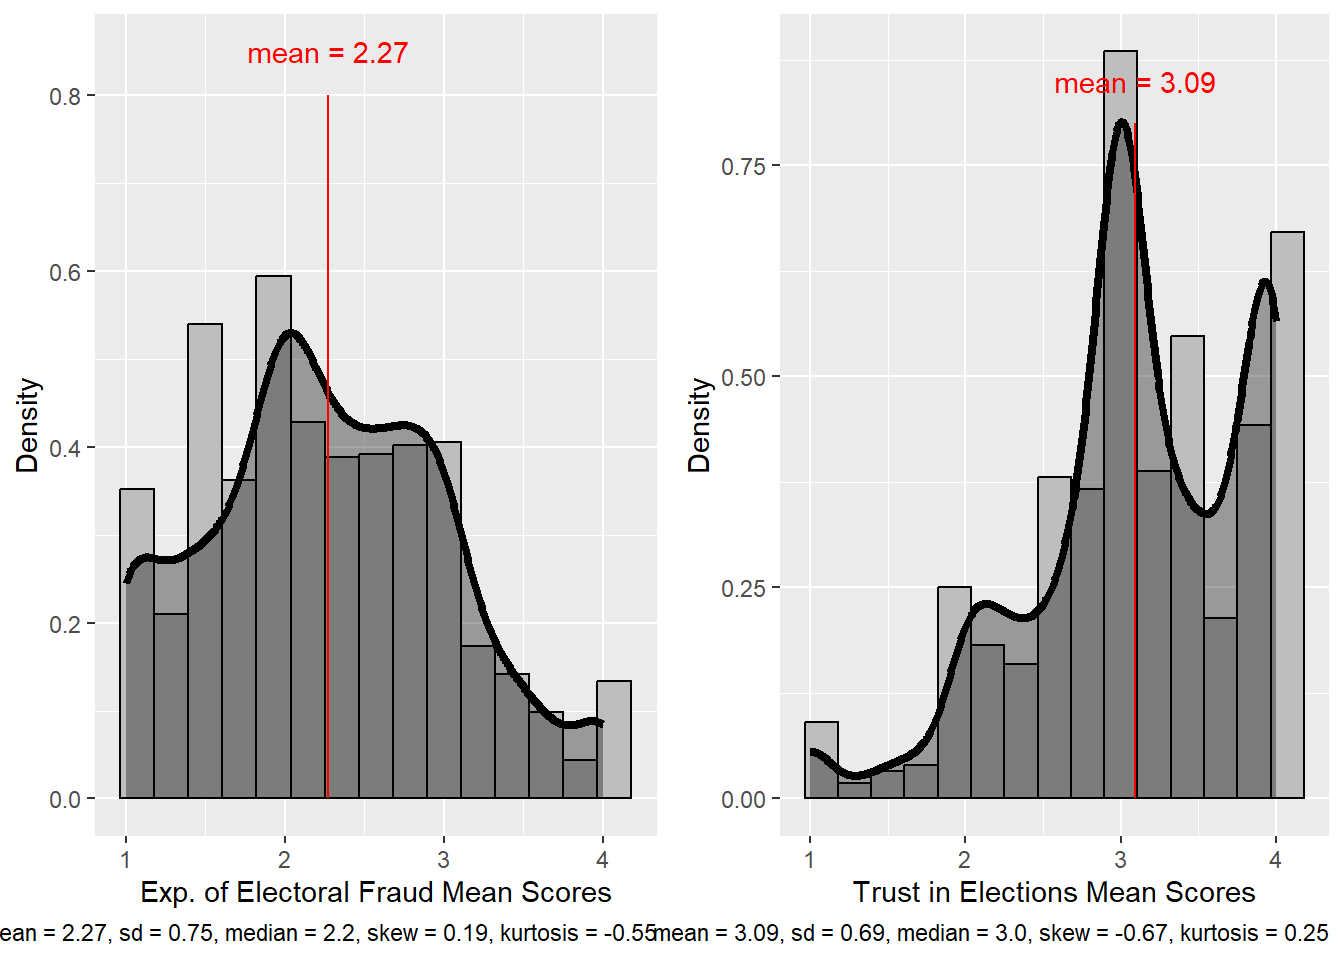

In [ ]:
# trust scores are not normally distributed, bi-modal, neg skew
trst.scores.hist <- ggplot(data, aes(trst.mean.scores))+
  geom_histogram(aes(y = after_stat(density)), bins = 15,
                 color = 1, fill = "grey")+
  geom_density(lwd = 1.5, color = 1, fill = 1, alpha = 0.35)+
  geom_segment(x = round(mean(data$trst.mean.scores), 2), y = 0, yend = 0.80, color = "red")+
  labs(
    x = "Trust in Elections Mean Scores",
    y = "Density",
    caption = "mean = 3.09, sd = 0.69, median = 3.0, skew = -0.67, kurtosis = 0.25"
  )+
  annotate("text", x = round(mean(data$trst.mean.scores), 2), y = 0.85,
           label = paste("mean =", round(mean(data$trst.mean.scores), 2)), color = "red")


# eef scores are not normally distributed, also bi-modal pos skew
eef.scores.hist <- ggplot(data, aes(eef.mean.scores))+
  geom_histogram(aes(y = after_stat(density)), bins = 15,
                 color = 1, fill = "grey")+
  geom_density(lwd = 1.5, color = 1, fill = 1, alpha = 0.35)+
  geom_segment(x = round(mean(data$eef.mean.scores), 2), y = 0, yend = 0.80, color = "red")+
  labs(
    x = "Exp. of Electoral Fraud Mean Scores",
    y = "Density",
    caption = "mean = 2.27, sd = 0.75, median = 2.2, skew = 0.19, kurtosis = -0.55"
  )+
  annotate("text", x = round(mean(data$eef.mean.scores), 2), y = 0.85,
           label = paste("mean =", round(mean(data$eef.mean.scores), 2)), color = "red")

# place plots side by side
gridExtra::grid.arrange(eef.scores.hist, trst.scores.hist, ncol = 2)

Given the non-normal (or at least un-equal skew of the) distribution of the two scale scores and ordinal nature of the variable items, I conducted a Spearman’s rank correlation test \[@spearman1907\] and found a negative correlation of $\rho$ -0.49 (Kendall’s = -0.39) between summated scores on the two scales.

The negative correlation between the items and the composite scores makes sense. Theoretically speaking, a person who is certain that electoral fraud will occur clearly lacks trust in the election. That is, expectation of electoral fraud does imply lack of trust in elections. However, the reverse isn’t also necessarily true; it is reasonable to hold a degree of trust in elections alongside expectations that electoral fraud will occur. Holding both considerations isn’t necessarily an example of cognitive dissonance, as a lack of confidence in elections doesn’t necessarily imply an expectation of electoral fraud. A lack of trust in elections might render one open to potentialities, but expectation of fraud is in no way necessitated by lacking trust in elections. When considered along a spectrum, both can be considered as degrees of *confidence*; and in the absence of confidence, insecure.

Accordingly, those whose responses to the “trust in elections” items would be cancelled out by their responses to the “expectation of fraud” items. Those who are, or are close to being, equally confident in both directions would be the most *insecure* about their expectations\[^Insecure in terms of their confidence. Not insecure as to imply some anxious or concerned affect.\]. Having no trust in elections and no expectation that electoral fraud will occur is functionally equivalent to having equal degree of both. Quite literally, an uncertain feeling of “it could go one way or the other”. Operationally, this would reflect a middling 0 on a scale of *confidence*. Seeing as how expectation of electoral fraud is also a level of confidence, then it is reasonable to place all items onto a symmetric scale where positive values represent trust in elections and negative values represent expectation of electoral fraud.

The primary dependent variable is *confidence in elections*, which reflects one’s trust in election administration minus their expectations of electoral fraud. Operationally, the dependent variable is a linear composite scale of item responses across items measuring trust in elections and expectations of electoral fraud re-scaled to range from -3 to 3. Items comprising trust in elections were positively coded to range from 0 “Not at all confident/committed” to 3 “Very confident/committed”. Likewise, items capturing expectation of electoral fraud were coded negatively to range from 0 “Not likely at all” to -3 “Very likely”.

Computed mean or sum scores for multiple Likert items are commonly acceptable, as they are relatively robust in spite of violating assumptions of a normal distribution of data (or residuals). due to the somewhat non-normal distribution of the sum or mean scores and the ordinal nature of the variable items, an ordered regression analysis is preferred.

The primary independent variable is the prospect of military veterans as election workers (i.e., staff or volunteers).

## Results

The key question is whether trust in elections (or voter confidence) is response to the treatment vignette.

Note that the question wording for the survey items derived from the 2022 SPAE are modified slightly but substantially. The question wording in this study is most similar to those in 2022 SPAE that assess confidence that votes will be counted as voters intend without specific reference to their own vote (e.g., in their county, state, or nationwide). In this study, two survey items ask about confidence in vote counts in one specific county in Arizona and another referencing their local community. Moreover, the 2022 SPAE includes “I don’t know” as a response option, whereas the comparable item in this study did not include a “don’t know” response option. Comparison between responses to the two similar items was conducted….

## Conclusion

### Limitations

-   limitations: interpretations of the treatment effect are limited.
    -   The sample may not be generalizable to the population.
    -   It’s hard to say whether merely mentioning veterans is enough, as compared to explicitly naming veterans as the target of particular recruitment efforts.
-   Interpretation is also limited considering that no other particular group, or groups are compared directly against the veteran treatment vignette, i.e., additional vignettes for other comparable groups.
-   Moreover, results are limited by the survey questions, questionnaire design, and experimental stimulus (i.e., vignette) for two reasons. - First, the vignettes and many survey questions ask about Maricopa County, AZ specifically. Adding a specific county in the vignette adds in a factor that cannot be accounted for without additional treatments that eliminate the setting as a potential influence. Moreover, the specificity of the setting adds in even more unexplained error—some people may have attitudes about the county in question, others won’t, while others may be muffed to consider a random county in the U.S. they’ve know nothing about. Adding the county undermines the confidence that treatment effects are solely attributable to veterans to an unknown degree. - Second, questions ask about one’s own local community in addition to identical questions which asked about Maricopa County, AZ. Consequently, many questions within the questionnaire were duplicates with that one differences. This isn’t uncommon in surveys, however in this case, it lengthened the survey to a degree that likely resulted in a higher drop off rate. More importantly, the quality of responses were likely diminished to some unknown extent. Although it is possible to compare questions asked about Maricopa County, AZ to questions about one’s local area, the quality of that comparison is limited by the unknown extent of fatigue induced by answering the same questions twice. It wasn’t just that some questions were asked multiple times, almost all of the questions were duplicated; after completing a long series on Maricopa County, participants then answered the same questions about the local community. The rate to which participants dropped from the survey is \_\_\_, which suggests fatigue as an important factor. Survey fatigue is a known issue that should be taken into consideration. Comparison of treatment effects between the MC series and the local area series is undermined by the unknown influence that fatigue would have on response choices. Any differences couldn’t confidently be attributed to “my area” vs Maricopa county. We also can’t determine whether treatment effects are sustained when comparing the Maricopa County series to the local area series asked subsequently. We would have to assume the setting as irrelevant, which we can’t reasonably do.

## Appendix A: Survey Experiment Vignettes

## Appendix B: Sample Demographics

The median age was 46 (mean age was 47). There was 51.7% (n = 658) women, 47% (n = 598) men, and approximately 1.3% who identified as either Non-binary/third gender (n = 7) or preferred not to say (n = 9). A large proportion of the sample identified as White or Caucasian (n = 975, 76.65%), while all other non-White respondents comprised 27.83% of the sample. Those who held a graduate level degree (e.g., Master’s, Doctorate, or Professional level) comprised 13% of the sample; those with either degree at the Associate or Bachelor’s level comprised 36.24%, while 22.25% had some college but no degree; and 28.46% had either a high school level or equivalent education or less than high school. The largest proportion of the sample identified as Democrat at 44.64%, followed by Republicans at 42.59%. The proportion of true Independents was 12.78%.

There should be nothing below here